# Fine-tune Llama 3.1 for Hate Speech Classification

This notebook fine-tunes a Llama 3.1 model for hate-speech classification using a LoRA approach, following the tutorial at DataCamp: https://www.datacamp.com/tutorial/fine-tuning-llama-3-1.

Replace `model_name` with your chosen model (e.g., `llama-3.1-8b-it`).

In [18]:
import torch
import bitsandbytes as bnb
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
from trl import SFTTrainer

In [19]:
import pandas as pd

train_path = 'data/hate_train.csv'

base_df = pd.read_csv(train_path)
base_df.head()

,sentence,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [20]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

def prepare_dataset(path, test_size=0.2, random_state=42):
    ds = pd.read_csv(path)
    ds = ds.rename(columns={'sentence': 'text'})

    train_df, val_df = train_test_split(ds, test_size=test_size, random_state=random_state, shuffle=True)
    
    # TODO: Remove after experiments
    train_df = train_df.iloc[:2000].reset_index(drop=True)
    val_df = val_df.iloc[:400].reset_index(drop=True)
    
    train = Dataset.from_pandas(train_df.reset_index(drop=True))
    val = Dataset.from_pandas(val_df.reset_index(drop=True))

    def make_prompt(ex):
        label = "1" if ex["label"] == 1 else "0"
        return {"text": f"Sklasyfikuj czy tekst spełnia normy kulturalnej wypowiedzi - jeśli tak, podaj 0, jeśli nie, podaj 1.\n\ntekst: {ex['text']}\nwartość: {label}"}

    train = train.map(make_prompt, remove_columns=["text", "label"])
    val = val.map(make_prompt, remove_columns=["text", "label"])
    return train, val

train_ds, eval_ds = prepare_dataset(train_path)

print(f"Train dataset size: {len(train_ds)}")
print(f"Eval dataset size: {len(eval_ds)}")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Train dataset size: 2000
Eval dataset size: 400


In [21]:
model_name = "speakleash/Bielik-7B-Instruct-v0.1"
output_dir = "bielik-hate-speech"
epochs = 1
batch_size = 1

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
)
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

target_modules = [
    name for name, module in model.named_modules()
    if isinstance(module, bnb.nn.Linear4bit)
]
peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    optim="paged_adamw_32bit",
    fp16=True,
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=50,
    save_total_limit=2,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    peft_config=peft_config
)
trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuning complete! Model saved to {output_dir}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Converting train dataset to ChatML:   0%|          | 0/2000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/400 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
50,1.170500,0.909252
100,0.844600,0.826843
150,0.842300,0.813947
200,0.796600,0.808645
250,0.797600,0.804931


Fine-tuning complete! Model saved to bielik-hate-speech


In [30]:
batch_size = 24
prompts = []
true_labels = []

for sample in eval_ds:
    full = sample["text"]
    prefix, true = full.rsplit("wartość:", 1)
    prompts.append(prefix + "wartość:")
    true_labels.append(1 if true.strip()=="1" else 0)

# now tokenize in batches and generate
preds = []
device = next(model.parameters()).device

for i in range(0, len(prompts), batch_size):
    batch_prompts = prompts[i : i+batch_size]
    batch_labels  = true_labels[i : i+batch_size]
    
    batch_inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    with torch.no_grad():
        outs = model.generate(
            **batch_inputs,
            max_new_tokens=4,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,        # make sure caching is on
            num_beams=1,           # greedy search
            do_sample=False        # deterministic
        )
    
    # decode the newly generated tokens for each example
    for seq, prompt in zip(outs, batch_prompts):
        gen = tokenizer.decode(
            seq[ len(batch_inputs["input_ids"][0]) : ],
            skip_special_tokens=True
        ).strip().split()[0]
        preds.append(1 if gen.lower().startswith("1") else 0)

labels = true_labels

acc = sum([1 if p==l else 0 for p, l in zip(preds, labels)]) / len(labels)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9250


In [31]:
# per class accuracy
class_0_acc = sum([1 if p==l and l==0 else 0 for p, l in zip(preds, labels)]) / sum([1 if l==0 else 0 for l in labels])
class_1_acc = sum([1 if p==l and l==1 else 0 for p, l in zip(preds, labels)]) / sum([1 if l==1 else 0 for l in labels])

print(f"Class 0 accuracy: {class_0_acc:.4f}")
print(f"Class 1 accuracy: {class_1_acc:.4f}")

Class 0 accuracy: 0.9863
Class 1 accuracy: 0.3056


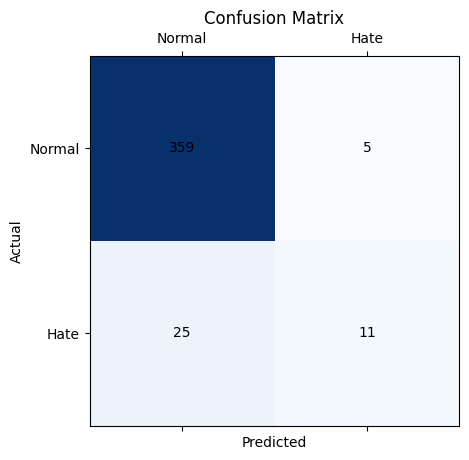

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

id2label = {0: "Normal", 1: "Hate"}

df = pd.DataFrame({'Actual': labels, 'Predicted': preds})
cm = pd.crosstab(df['Actual'], df['Predicted'], dropna=False)

fig, ax = plt.subplots()
cax = ax.matshow(cm)  # default colormap
cax.set_cmap('Blues')  # set colormap to 'Blues'

for (i, j), v in np.ndenumerate(cm.values):
    ax.text(j, i, v, ha='center', va='center')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.set_xticks(cm.columns.tolist())
ax.set_xticklabels([id2label[x] for x in cm.columns.tolist()])
ax.set_yticks(cm.index.tolist())
ax.set_yticklabels([id2label[y] for y in cm.index.tolist()])
plt.show()

In [16]:
# Identify misclassified samples
mis_idx = [i for i, (true, pred) in enumerate(zip(labels, preds)) if true != pred]

print(f"Total misclassifications: {len(mis_idx)}\n")

for idx in mis_idx:
    prompt = eval_ds[idx]["text"]
    # extract the original sentence
    sentence = prompt.split("text: ")[1].split("\nlabel:")[0]
    actual = id2label[labels[idx]]
    predicted = id2label[preds[idx]]
    print(f"#{idx}  Actual: {actual}  Predicted: {predicted}")
    print(sentence)
    print("-" * 80)

Total misclassifications: 30

#3  Actual: Hate  Predicted: Normal
@anonymized_account @anonymized_account Czyli tylko dlatego nie napiszesz o konkretach 😂 dziękujemy łaskawco inaczej bylibyśmy już pogrążeni
--------------------------------------------------------------------------------
#6  Actual: Hate  Predicted: Normal
@anonymized_account Urban powinien się od was uczyć. Jesteście żenujące gnojki. Aż przykro patrzeć.
--------------------------------------------------------------------------------
#12  Actual: Hate  Predicted: Normal
@anonymized_account Pierdolisz tyle o ojczyźnie to ją szanuj, 1200 zł na m-c za taksówki to nie jest szacunek,
--------------------------------------------------------------------------------
#18  Actual: Hate  Predicted: Normal
@anonymized_account hehe niech uważa bo jeszcze ktoś uwierzy że będzie stawiał na wychowanki
--------------------------------------------------------------------------------
#31  Actual: Hate  Predicted: Normal
@anonymized_accoun